In [ ]:
import copy
import requests
from PIL import Image
from io import BytesIO

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import torch, torchvision
from torch import nn
from torch import optim
from torchvision import transforms, datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 64
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
T = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = DataLoader(train_data, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_data, batch_size=BATCH_SIZE)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
class alexnet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = self.__conv2d(1, 96, 11, 4, 0, 1, 1, 3, 2)
        self.conv2 = self.__conv2d(96, 256, 5, 1, 2, 1, 1, 3, 2)
        self.conv3 = self.__conv2d(256, 384, 3, 1, 1, 1, 0)
        self.conv4 = self.__conv2d(384, 384, 3, 1, 1, 1, 0)
        self.conv5 = self.__conv2d(384, 256, 3, 1, 1, 1, 1, 3, 2)
        self.fc1 = self.__linear(256*6*6, 4096)
        self.fc2 = self.__linear(4096, 4096)
        self.fc3 = self.__linear(4096, 10)

    def __linear(self, in_features, out_features):
        return nn.Linear(in_features, out_features)

    def __conv2d(self, in_channels, out_channels, kernel_size, stride=1, padding=0, relu=True, maxpool=False, maxpool_kernel=0, maxpool_stride=0):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
        if relu:
            layers.append(nn.ReLU())
        if maxpool:
            layers.append(nn.MaxPool2d(maxpool_kernel, maxpool_stride))
        return nn.Sequential(*layers)

    def forward(self, t):
        out = self.conv1(t)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

    def __filter_weights(self, conv):
        weights = {}
        for idx, value in enumerate(conv[0].weight):
            weights[idx+1] = float(value.sum())

        return dict(sorted(weights.items(), key=lambda x:x[1]))

    def weights(self):
        return {
            "Conv1D": self.__filter_weights(self.conv1),
            "Conv2D": self.__filter_weights(self.conv2),
            "Conv3D": self.__filter_weights(self.conv3),
            "Conv4D": self.__filter_weights(self.conv4),
            "Conv5D": self.__filter_weights(self.conv5),
        }

In [ ]:
model = alexnet().to(device)
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters())

In [ ]:
conv1_grad = []
conv2_grad = []
conv3_grad = []
conv4_grad = []
conv5_grad = []

In [ ]:
def train(model, device, train_loader, optimer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (batch_idx + 1) % 1000 == 0:
          conv1_grad.append(np.concatenate(model.conv1[0].weight.grad.cpu().numpy().copy(), axis=0))
          conv2_grad.append(np.concatenate(model.conv2[0].weight.grad.cpu().numpy().copy(), axis=0))
          conv3_grad.append(np.concatenate(model.conv3[0].weight.grad.cpu().numpy().copy(), axis=0))
          conv4_grad.append(np.concatenate(model.conv4[0].weight.grad.cpu().numpy().copy(), axis=0))
          conv5_grad.append(np.concatenate(model.conv5[0].weight.grad.cpu().numpy().copy(), axis=0))
        if (batch_idx + 1) % 100 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [ ]:
EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    train(model, device, train_dl, optimizer, epoch)
    validate(model, device, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch:1 [6336/60000 (11%)]	Loss: 0.246877
Train Epoch:1 [12736/60000 (21%)]	Loss: 0.407131
Train Epoch:1 [19136/60000 (32%)]	Loss: 0.198927
Train Epoch:1 [25536/60000 (43%)]	Loss: 0.141111
Train Epoch:1 [31936/60000 (53%)]	Loss: 0.344709
Train Epoch:1 [38336/60000 (64%)]	Loss: 0.286212
Train Epoch:1 [44736/60000 (75%)]	Loss: 0.087947
Train Epoch:1 [51136/60000 (85%)]	Loss: 0.065966
Train Epoch:1 [57536/60000 (96%)]	Loss: 0.028106

Test set: Average loss: 0.0915, Accuracy: 9733/10000 (97%)



In [ ]:
sdsd = model.conv1[0].weight.grad[0][0].data.cpu().numpy()

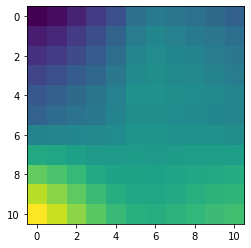

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(sdsd)

# Trained Model

In [ ]:
trained_model = torch.load('/content/drive/MyDrive/Research/Pruning/model')

# Pruned Model

In [ ]:
prune = {
    "conv1": 1,
    "conv2": 2,
    "conv3": 2,
    "conv4": 2,
    "conv5": 2
}

p_data = {}
for key, value in dict(trained_model.named_parameters()).items():
    if "conv" in key:
        if "weight" in key:
            values = value.sum(dim=[1,2,3]).tolist()
            mean, sigma = np.mean(values), np.std(values)
            filter_values = dict(zip([*range(len(value))], values))
            filters = [filter for (filter, data) in filter_values.items() if data > mean-sigma*prune[str(key[:5])]]
            if "conv1" in key:
                p_data[str(key[:5])] = {0: filters, 1: filters}
            else:
                p_data[str(key[:5])] = {0: filters}

p_data["conv2"][1] = p_data["conv1"][0]
p_data["conv3"][1] = p_data["conv2"][0]
p_data["conv4"][1] = p_data["conv3"][0]
p_data["conv5"][1] = p_data["conv4"][0]

In [ ]:
class alexnet_pruned(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = self.__conv2d(1, 81, 11, 4, 0, 1, 1, 3, 2)
        self.conv2 = self.__conv2d(81, 245, 5, 1, 2, 1, 1, 3, 2)
        self.conv3 = self.__conv2d(245, 378, 3, 1, 1, 1, 0)
        self.conv4 = self.__conv2d(378, 374, 3, 1, 1, 1, 0)
        self.conv5 = self.__conv2d(374, 248, 3, 1, 1, 1, 1, 3, 2)
        self.fc1 = self.__linear(248*6*6, 4096)
        self.fc2 = self.__linear(4096, 4096)
        self.fc3 = self.__linear(4096, 10)

    def __linear(self, in_features, out_features):
        return nn.Linear(in_features, out_features)

    def __conv2d(self, in_channels, out_channels, kernel_size, stride=1, padding=0, relu=True, maxpool=False, maxpool_kernel=0, maxpool_stride=0):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
        if relu:
            layers.append(nn.ReLU())
        if maxpool:
            layers.append(nn.MaxPool2d(maxpool_kernel, maxpool_stride))
        return nn.Sequential(*layers)

    def forward(self, t):
        out = self.conv1(t)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)
        return out

    def __filter_weights(self, conv):
        weights = {}
        for idx, value in enumerate(conv[0].weight):
            weights[idx+1] = float(value.sum())

        return dict(sorted(weights.items(), key=lambda x:x[1]))

    def weights(self):
        return {
            "Conv1D": self.__filter_weights(self.conv1),
            "Conv2D": self.__filter_weights(self.conv2),
            "Conv3D": self.__filter_weights(self.conv3),
            "Conv4D": self.__filter_weights(self.conv4),
            "Conv5D": self.__filter_weights(self.conv5),
        }

In [ ]:
new_model = alexnet_pruned().to(device)

for (player,pvalue), (nlayer,nvalue) in zip(dict(pruned_model.named_parameters()).items(), dict(new_model.named_parameters()).items()):
    if "conv" in player:
        if "weight" in player:
            data = p_data[str(player)[:5]]
            if "1" in player:
                i = 0
                for filt in data[0]:
                    nvalue.data[i] = pvalue.data[filt]
                    i = i+1
            else:
                i, j = 0, 0
                for zero in data[0]:
                    for first in data[1]:
                        nvalue.data[i][j] = pvalue.data[zero][first]
                        j = j+1
                    i = i+1
                    break

In [ ]:
%%time
validate(trained_model, device, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Test set: Average loss: 0.0685, Accuracy: 9833/10000 (98%)

CPU times: user 15.4 s, sys: 106 ms, total: 15.5 s
Wall time: 15.6 s


In [ ]:
%%time
validate(pruned_model, device, val_dl)


Test set: Average loss: 0.0674, Accuracy: 9814/10000 (98%)

CPU times: user 15.3 s, sys: 136 ms, total: 15.5 s
Wall time: 15.4 s


In [ ]:
import torch
from torchvision.models import resnet18

from pthflops import count_ops

# Create a network and a corresponding input
device = 'cuda:0'
model = resnet18().to(device)
inp = torch.rand(1,3,224,224).to(device)

# Count the number of FLOPs
count_ops(model, inp)

ModuleNotFoundError: ignored